In [1]:
%reset

# Importamos las librerias.
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense
from keras import optimizers
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalAveragePooling1D, Permute
from keras.models import load_model

from keras.utils.np_utils import to_categorical

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


C:\Users\Juan\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# IMPORTAMOS EL DATASET

### En las siguientes celdas formalizaremos los datos de entrada

In [2]:
# Creamos el DataFrame con los datos del archivo 'GAS.MC-4.csv'.
Historico = pd.read_csv('GAS.MC-4.csv')

Close = Historico['Close']
Date = Historico['Date']

Close = Close.astype(float)

#Almacenamos en esta variable el total de los datos, ponemos el -30 porque de el primer valor que tenemos los 30 anteriores es el 
#valor en la posición 31, entonces tendremos len(close)-30 datos para entrenamiento y validación.
TotalDatos = len(Close)-30

#Cogemos el 80 % de los datos para el entrenamiento
DatosEntrenamiento = round((80*TotalDatos)/100)

#print(DatosEntrenamiento)
#print(TotalDatos)
#print(len(Close))

# DATOS CONJUNTO ENTRENAMIENTO

## Entradas

In [3]:
#Inicializamos la matriz, ponemos el menos 30 porque el primer vector seran los datos del 0-30
matrizDatosEntrenamiento = np.zeros((DatosEntrenamiento-30,30))

aux=0
aux2= 30

# Este for sirve para recorrer nuestros datos y guardar desde el el dato 31
for i in range (0, DatosEntrenamiento-30):
    
    ##Creamos vector Datos (maximo 30 datos) y se sobrescribe
    cont=0
    for j in range (aux, aux2):
            
        matrizDatosEntrenamiento[i][cont] = np.array(Close[j])
        cont = cont+1
        
    aux = aux + 1
    aux2 = aux2 + 1
    
matrizDatosEntrenamiento

matrizDatosEntrenamiento = np.expand_dims(matrizDatosEntrenamiento, axis=2)

## Salidas

In [4]:
SalidaAux = np.zeros(DatosEntrenamiento-30)
SalidasClases = np.zeros((DatosEntrenamiento-30, 10))
variaciones = np.zeros((DatosEntrenamiento-30))
col = np.zeros((10))

#Calculamos la todos los porcentajes de subida y bajada de cada salida
for x in range(30, DatosEntrenamiento):
    dato1 = Close[x-1]
    dato2 = Close[x]
    
    variaciones[x-30] = (dato2-dato1)*100/dato1
    
#Cogemos la maxima subida y la maxima bajada
maximaVar = max(variaciones)
minimaVar = min(variaciones)

#Creamos el intervalo entre el minimo y el maximo, y las dividimos entre 10 para crear 10 clases
intervalo = maximaVar - minimaVar
intervalo = intervalo/10

for x in range(0, DatosEntrenamiento-30):
    
    #Segun la salida que nos da la metemos en un grupo u otro
    if (variaciones[x] >= minimaVar and variaciones[x] < minimaVar+intervalo):
        SalidasClases[x] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
        col[0]+=1
    
    elif (variaciones[x] >= minimaVar+intervalo and variaciones[x] < minimaVar+intervalo*2):
        SalidasClases[x] = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        col[1]+=1
    
    elif (variaciones[x] >= minimaVar+intervalo*2 and variaciones[x] < minimaVar+intervalo*3):
        SalidasClases[x] = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        col[2]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*3 and variaciones[x] < minimaVar+intervalo*4):
        SalidasClases[x] = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
        col[3]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*4 and variaciones[x] < minimaVar+intervalo*5):
        SalidasClases[x] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        col[4]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*5 and variaciones[x] < minimaVar+intervalo*6):
        SalidasClases[x] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
        col[5]+=1
    
    elif (variaciones[x] >= minimaVar+intervalo*6 and variaciones[x] < minimaVar+intervalo*7):
        SalidasClases[x] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
        col[6]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*7 and variaciones[x] < minimaVar+intervalo*8):
        SalidasClases[x] = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
        col[7]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*8 and variaciones[x] < minimaVar+intervalo*9):
        SalidasClases[x] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
        col[8]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*9 and variaciones[x] <= maximaVar):
        SalidasClases[x] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        col[9]+=1

# DATOS CONJUNTO DE VALIDACIÓN

## Entradas

In [5]:
matrizDatosEvaluate = np.zeros(((len(Close)-DatosEntrenamiento), 30, 1))

aux=DatosEntrenamiento-30
aux2= DatosEntrenamiento

# Este for sirve para recorrer nuestros datos y guardar desde el el dato 31
for i in range (0,(len(Close)-DatosEntrenamiento)):
    
    ##Creamos vector Datos (maximo 30 datos) y se sobrescribe
    cont=0
    for j in range (aux, aux2):
            
        matrizDatosEvaluate[i][cont] = np.array(Close[j])
        cont = cont+1
        
    aux = aux + 1
    aux2 = aux2 + 1
    
print('Número de datos para la validación: ', len(Close)-DatosEntrenamiento)

Número de datos para la validación:  672


## Salidas

In [6]:
salidaValidacion = np.zeros((len(Close)-DatosEntrenamiento, 10))

#Calculamos la todos los porcentajes de subida y bajada de cada salida
for x in range(DatosEntrenamiento, len(Close)):
    dato1 = Close[x-1]
    dato2 = Close[x]
    
    variaciones[x-DatosEntrenamiento] = (dato2-dato1)*100/dato1

for x in range(0, len(Close)-DatosEntrenamiento):
    
    #Segun la salida que nos da la metemos en un grupo u otro
    if (variaciones[x] >= minimaVar and variaciones[x] < minimaVar+intervalo):
        salidaValidacion[x] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
        col[0]+=1
    
    elif (variaciones[x] >= minimaVar+intervalo and variaciones[x] < minimaVar+intervalo*2):
        salidaValidacion[x] = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        col[1]+=1
    
    elif (variaciones[x] >= minimaVar+intervalo*2 and variaciones[x] < minimaVar+intervalo*3):
        salidaValidacion[x] = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        col[2]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*3 and variaciones[x] < minimaVar+intervalo*4):
        salidaValidacion[x] = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
        col[3]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*4 and variaciones[x] < minimaVar+intervalo*5):
        salidaValidacion[x] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        col[4]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*5 and variaciones[x] < minimaVar+intervalo*6):
        salidaValidacion[x] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
        col[5]+=1
    
    elif (variaciones[x] >= minimaVar+intervalo*6 and variaciones[x] < minimaVar+intervalo*7):
        salidaValidacion[x] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
        col[6]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*7 and variaciones[x] < minimaVar+intervalo*8):
        salidaValidacion[x] = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
        col[7]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*8 and variaciones[x] < minimaVar+intervalo*9):
        salidaValidacion[x] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
        col[8]+=1
        
    elif (variaciones[x] >= minimaVar+intervalo*9 and variaciones[x] <= maximaVar):
        salidaValidacion[x] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        col[9]+=1

# DATOS PARA PREDECIR, 2018 (Hasta el 27-04)

In [7]:
DatosPredicción = pd.read_csv('Predict_GAS_2018.csv')
DatosPredicción

Cierre = DatosPredicción['Close']

Cierre = Cierre.astype(float)

matrizDatosPredicción = np.zeros((len(Cierre)-30+1, 30, 1))

aux=0
aux2= 30


# Este for sirve para recorrer nuestros datos y guardar desde el el dato 31
for i in range (0, len(Cierre)-30+1):
    
    ##Creamos vector Datos (maximo 30 datos) y se sobrescribe
    cont=0
    for j in range (aux, aux2):
            
        matrizDatosPredicción[i][cont] = np.array(Cierre[j])
        cont = cont+1
        
    aux = aux + 1
    aux2 = aux2 + 1

# CONSTRUIMOS LA RED NEURONAL

In [8]:
model = Sequential()

#Añadimos todas las capas de convolucion, pooling y dropout necesarias
model.add(Conv1D(8, kernel_size=(3), activation='relu', input_shape=(30, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

#Definimos la función de error y la función de optimización
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(matrizDatosEntrenamiento, SalidasClases, epochs = 2000)

#model.save('MLP.h5')


Epoch 1/2000
2538/2538 [==============================] - 1s 590us/step - loss: 1.4016 - acc: 0.4846
Epoch 2/2000
2538/2538 [==============================] - 0s 144us/step - loss: 1.3255 - acc: 0.5276
Epoch 3/2000
2538/2538 [==============================] - 0s 141us/step - loss: 1.3084 - acc: 0.5193
Epoch 4/2000
2538/2538 [==============================] - 0s 132us/step - loss: 1.2847 - acc: 0.5280
Epoch 5/2000
2538/2538 [==============================] - 0s 138us/step - loss: 1.2735 - acc: 0.5288
Epoch 6/2000
2538/2538 [==============================] - 0s 124us/step - loss: 1.2568 - acc: 0.5299
Epoch 7/2000
2538/2538 [==============================] - 0s 138us/step - loss: 1.2550 - acc: 0.5315
Epoch 8/2000
2538/2538 [==============================] - 0s 149us/step - loss: 1.2395 - acc: 0.5292
Epoch 9/2000
2538/2538 [==============================] - 0s 142us/step - loss: 1.2368 - acc: 0.5311
Epoch 10/2000
2538/2538 [==============================] - 0s 119us/step - loss: 1.2556 - a

2538/2538 [==============================] - 0s 85us/step - loss: 1.0578 - acc: 0.5792
Epoch 162/2000
2538/2538 [==============================] - 0s 93us/step - loss: 1.0520 - acc: 0.5820
Epoch 163/2000
2538/2538 [==============================] - 0s 90us/step - loss: 1.0415 - acc: 0.5839
Epoch 164/2000
2538/2538 [==============================] - 0s 87us/step - loss: 1.0468 - acc: 0.5871
Epoch 165/2000
2538/2538 [==============================] - 0s 85us/step - loss: 1.0555 - acc: 0.5796
Epoch 166/2000
2538/2538 [==============================] - 0s 87us/step - loss: 1.0473 - acc: 0.5792
Epoch 167/2000
2538/2538 [==============================] - 0s 85us/step - loss: 1.0405 - acc: 0.5800
Epoch 168/2000
2538/2538 [==============================] - 0s 91us/step - loss: 1.0549 - acc: 0.5757
Epoch 169/2000
2538/2538 [==============================] - 0s 85us/step - loss: 1.0316 - acc: 0.5820
Epoch 170/2000
2538/2538 [==============================] - 0s 91us/step - loss: 1.0354 - acc: 0.

2538/2538 [==============================] - 0s 85us/step - loss: 0.9795 - acc: 0.6103
Epoch 242/2000
2538/2538 [==============================] - 0s 87us/step - loss: 0.9878 - acc: 0.6013
Epoch 243/2000
2538/2538 [==============================] - 0s 89us/step - loss: 0.9680 - acc: 0.6131
Epoch 244/2000
2538/2538 [==============================] - 0s 88us/step - loss: 0.9791 - acc: 0.6095
Epoch 245/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.9723 - acc: 0.6103
Epoch 246/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.9843 - acc: 0.6068
Epoch 247/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.9645 - acc: 0.6139
Epoch 248/2000
2538/2538 [==============================] - 0s 88us/step - loss: 0.9701 - acc: 0.6060
Epoch 249/2000
2538/2538 [==============================] - 0s 85us/step - loss: 1.0039 - acc: 0.6044
Epoch 250/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.9949 - acc: 0.

2538/2538 [==============================] - 0s 85us/step - loss: 0.8905 - acc: 0.6391
Epoch 402/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.8733 - acc: 0.6556
Epoch 403/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.8764 - acc: 0.6513
Epoch 404/2000
2538/2538 [==============================] - 0s 87us/step - loss: 0.8676 - acc: 0.6568
Epoch 405/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.8831 - acc: 0.6596
Epoch 406/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.9065 - acc: 0.6340
Epoch 407/2000
2538/2538 [==============================] - 0s 90us/step - loss: 0.8827 - acc: 0.6422
Epoch 408/2000
2538/2538 [==============================] - 0s 87us/step - loss: 0.8808 - acc: 0.6501
Epoch 409/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.8764 - acc: 0.6470
Epoch 410/2000
2538/2538 [==============================] - 0s 92us/step - loss: 0.8685 - acc: 0.

2538/2538 [==============================] - 0s 96us/step - loss: 0.8489 - acc: 0.6710
Epoch 482/2000
2538/2538 [==============================] - 0s 95us/step - loss: 0.8454 - acc: 0.6651
Epoch 483/2000
2538/2538 [==============================] - 0s 130us/step - loss: 0.8313 - acc: 0.6671
Epoch 484/2000
2538/2538 [==============================] - 0s 95us/step - loss: 0.8497 - acc: 0.6749
Epoch 485/2000
2538/2538 [==============================] - 0s 92us/step - loss: 0.8530 - acc: 0.6612
Epoch 486/2000
2538/2538 [==============================] - 0s 95us/step - loss: 0.8588 - acc: 0.6529
Epoch 487/2000
2538/2538 [==============================] - 0s 109us/step - loss: 0.8357 - acc: 0.6682
Epoch 488/2000
2538/2538 [==============================] - 0s 101us/step - loss: 0.8439 - acc: 0.6623
Epoch 489/2000
2538/2538 [==============================] - 0s 102us/step - loss: 0.8502 - acc: 0.6619
Epoch 490/2000
2538/2538 [==============================] - 0s 98us/step - loss: 0.8673 - acc

2538/2538 [==============================] - 0s 85us/step - loss: 0.7988 - acc: 0.6883
Epoch 641/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7768 - acc: 0.6990
Epoch 642/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.7839 - acc: 0.6879
Epoch 643/2000
2538/2538 [==============================] - 0s 87us/step - loss: 0.7453 - acc: 0.7092
Epoch 644/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.7799 - acc: 0.6962
Epoch 645/2000
2538/2538 [==============================] - 0s 94us/step - loss: 0.7894 - acc: 0.6935
Epoch 646/2000
2538/2538 [==============================] - 0s 84us/step - loss: 0.8008 - acc: 0.6875
Epoch 647/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.7921 - acc: 0.6931
Epoch 648/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.7955 - acc: 0.6919
Epoch 649/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7529 - acc: 0.

2538/2538 [==============================] - 0s 91us/step - loss: 0.7600 - acc: 0.6998
Epoch 801/2000
2538/2538 [==============================] - 0s 87us/step - loss: 0.7680 - acc: 0.7033
Epoch 802/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7443 - acc: 0.7222
Epoch 803/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.7410 - acc: 0.7171
Epoch 804/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7735 - acc: 0.7002
Epoch 805/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7217 - acc: 0.7258
Epoch 806/2000
2538/2538 [==============================] - 0s 87us/step - loss: 0.7601 - acc: 0.7076
Epoch 807/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7513 - acc: 0.7104
Epoch 808/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7158 - acc: 0.7297
Epoch 809/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7622 - acc: 0.

2538/2538 [==============================] - 0s 100us/step - loss: 0.7136 - acc: 0.7301
Epoch 961/2000
2538/2538 [==============================] - 0s 95us/step - loss: 0.6760 - acc: 0.7423
Epoch 962/2000
2538/2538 [==============================] - 0s 86us/step - loss: 0.7025 - acc: 0.7289
Epoch 963/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6808 - acc: 0.7348
Epoch 964/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.7182 - acc: 0.7317
Epoch 965/2000
2538/2538 [==============================] - 0s 94us/step - loss: 0.7070 - acc: 0.7218
Epoch 966/2000
2538/2538 [==============================] - 0s 90us/step - loss: 0.7198 - acc: 0.7250
Epoch 967/2000
2538/2538 [==============================] - 0s 103us/step - loss: 0.6893 - acc: 0.7372
Epoch 968/2000
2538/2538 [==============================] - 0s 100us/step - loss: 0.7078 - acc: 0.7309
Epoch 969/2000
2538/2538 [==============================] - 0s 113us/step - loss: 0.7015 - acc

2538/2538 [==============================] - 0s 88us/step - loss: 0.6656 - acc: 0.7439
Epoch 1119/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6687 - acc: 0.7435
Epoch 1120/2000
2538/2538 [==============================] - 0s 92us/step - loss: 0.6907 - acc: 0.7364
Epoch 1121/2000
2538/2538 [==============================] - 0s 84us/step - loss: 0.7127 - acc: 0.7305
Epoch 1122/2000
2538/2538 [==============================] - 0s 94us/step - loss: 0.6970 - acc: 0.7270
Epoch 1123/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6438 - acc: 0.7482
Epoch 1124/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6752 - acc: 0.7478
Epoch 1125/2000
2538/2538 [==============================] - 0s 92us/step - loss: 0.6696 - acc: 0.7384
Epoch 1126/2000
2538/2538 [==============================] - 0s 80us/step - loss: 0.7021 - acc: 0.7419
Epoch 1127/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.6826 

2538/2538 [==============================] - 0s 83us/step - loss: 0.6632 - acc: 0.7522
Epoch 1277/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.7017 - acc: 0.7301
Epoch 1278/2000
2538/2538 [==============================] - 0s 88us/step - loss: 0.6481 - acc: 0.7561
Epoch 1279/2000
2538/2538 [==============================] - 0s 83us/step - loss: 0.6623 - acc: 0.7451
Epoch 1280/2000
2538/2538 [==============================] - 0s 87us/step - loss: 0.6656 - acc: 0.7522
Epoch 1281/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6771 - acc: 0.7427
Epoch 1282/2000
2538/2538 [==============================] - 0s 98us/step - loss: 0.6626 - acc: 0.7478
Epoch 1283/2000
2538/2538 [==============================] - 0s 86us/step - loss: 0.6641 - acc: 0.7447
Epoch 1284/2000
2538/2538 [==============================] - 0s 88us/step - loss: 0.6347 - acc: 0.7549
Epoch 1285/2000
2538/2538 [==============================] - 0s 88us/step - loss: 0.6549 

2538/2538 [==============================] - 0s 91us/step - loss: 0.6405 - acc: 0.7593
Epoch 1435/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.6367 - acc: 0.7541
Epoch 1436/2000
2538/2538 [==============================] - 0s 87us/step - loss: 0.6483 - acc: 0.7679
Epoch 1437/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.6315 - acc: 0.7660
Epoch 1438/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6178 - acc: 0.7640
Epoch 1439/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.6638 - acc: 0.7561
Epoch 1440/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.6254 - acc: 0.7577
Epoch 1441/2000
2538/2538 [==============================] - 0s 88us/step - loss: 0.6437 - acc: 0.7573
Epoch 1442/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6513 - acc: 0.7514
Epoch 1443/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6153 

2538/2538 [==============================] - 0s 85us/step - loss: 0.6104 - acc: 0.7667
Epoch 1593/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.6160 - acc: 0.7730
Epoch 1594/2000
2538/2538 [==============================] - 0s 92us/step - loss: 0.6241 - acc: 0.7593
Epoch 1595/2000
2538/2538 [==============================] - 0s 93us/step - loss: 0.6608 - acc: 0.7498
Epoch 1596/2000
2538/2538 [==============================] - 0s 97us/step - loss: 0.6414 - acc: 0.7628
Epoch 1597/2000
2538/2538 [==============================] - 0s 93us/step - loss: 0.6168 - acc: 0.7699
Epoch 1598/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.6007 - acc: 0.7801
Epoch 1599/2000
2538/2538 [==============================] - 0s 94us/step - loss: 0.6137 - acc: 0.7648
Epoch 1600/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.5930 - acc: 0.7801: 0s - loss: 0.5930 - acc: 0.776
Epoch 1601/2000
2538/2538 [==============================

2538/2538 [==============================] - 0s 91us/step - loss: 0.6026 - acc: 0.7742
Epoch 1751/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6078 - acc: 0.7809
Epoch 1752/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.5789 - acc: 0.7782
Epoch 1753/2000
2538/2538 [==============================] - 0s 93us/step - loss: 0.5943 - acc: 0.7750
Epoch 1754/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6118 - acc: 0.7648
Epoch 1755/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6075 - acc: 0.7687
Epoch 1756/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6010 - acc: 0.7778
Epoch 1757/2000
2538/2538 [==============================] - 0s 88us/step - loss: 0.6313 - acc: 0.7644
Epoch 1758/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.5983 - acc: 0.7727
Epoch 1759/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.6232 

2538/2538 [==============================] - 0s 91us/step - loss: 0.6086 - acc: 0.7837
Epoch 1909/2000
2538/2538 [==============================] - 0s 91us/step - loss: 0.5722 - acc: 0.7896
Epoch 1910/2000
2538/2538 [==============================] - 0s 85us/step - loss: 0.5786 - acc: 0.7849
Epoch 1911/2000
2538/2538 [==============================] - 0s 100us/step - loss: 0.6104 - acc: 0.7715
Epoch 1912/2000
2538/2538 [==============================] - 0s 112us/step - loss: 0.5737 - acc: 0.7817
Epoch 1913/2000
2538/2538 [==============================] - 0s 97us/step - loss: 0.6165 - acc: 0.7730
Epoch 1914/2000
2538/2538 [==============================] - 0s 100us/step - loss: 0.6007 - acc: 0.7774
Epoch 1915/2000
2538/2538 [==============================] - 0s 97us/step - loss: 0.5854 - acc: 0.7829
Epoch 1916/2000
2538/2538 [==============================] - 0s 99us/step - loss: 0.6426 - acc: 0.7632
Epoch 1917/2000
2538/2538 [==============================] - 0s 99us/step - loss: 0.57

In [9]:
#model = load_model('MLP.h5')

validacion = model.evaluate(matrizDatosEvaluate, salidaValidacion)

672/672 [==============================] - 0s 73us/step


## Dibujamos una representación del modelo y la gráfica del eeror

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 28, 8)             32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 8)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 8)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 112)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               57856     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 63,018
Trainable params: 63,018
Non-trainable params: 0
_________________________________________________________________


#### Pintamos gráfica del error para el conjunto entrenamiento

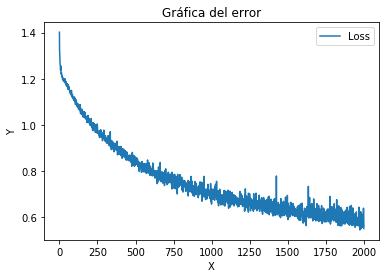

In [11]:
plt.plot(history.history['loss'])
plt.title('Gráfica del error')
plt.ylabel('Y')
plt.xlabel('X')
plt.legend(['Loss'], loc='upper right')
plt.show()

# PREDECIMOS

In [12]:
predicion = model.predict(matrizDatosPredicción)

print("Valor minimo:", minimaVar, "Valor maximo:", maximaVar, "Intercala cada:", intervalo)
print(predicion)

Valor minimo: -9.170785282811654 Valor maximo: 12.209562173865095 Intercala cada: 2.138034745667675
[[5.04705636e-03 8.98733793e-04 2.68843980e-03 4.56139714e-01
  1.18074082e-01 4.12131995e-01 4.96847508e-03 1.26482892e-05
  3.05198009e-05 8.35162518e-06]
 [1.30924024e-03 2.89971917e-03 3.49619170e-03 5.75208783e-01
  3.57840478e-01 5.64503260e-02 2.38332032e-05 4.73934400e-04
  2.28962675e-03 7.84370604e-06]
 [3.41114285e-03 1.03207743e-02 5.01226960e-03 7.07464457e-01
  2.55350769e-01 1.82545278e-02 6.62793536e-05 6.85410217e-09
  1.19726385e-04 3.96838082e-08]
 [2.85546005e-01 3.35483986e-04 7.65325967e-04 2.63934731e-02
  3.46760191e-02 6.49317801e-01 2.96497601e-03 1.43807526e-07
  6.70482109e-07 2.42656935e-08]
 [3.58580612e-02 4.03277751e-04 5.27320844e-06 3.51544112e-01
  5.82206428e-01 2.52950173e-02 4.68680728e-03 7.88248144e-07
  2.19150822e-10 3.02456556e-07]
 [2.06809145e-05 1.48703766e-04 3.90587887e-03 3.84085812e-02
  9.42970574e-01 1.08028008e-02 3.74173140e-03 3.4677